## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Jeff Herman
* Blog post URL:


# 1. Import libraries

In [1135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

import warnings
warnings.filterwarnings('ignore')

# 2. Obtain Data

In [1136]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 3. Scrub and Clean Data

### Check Data Types

In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [1138]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

### Check for Erroneous Values (i.e. ?)

In [1139]:
# sqft_basement includes 454 instances of '?'
sum(df['sqft_basement'] =='?')

454

In [1140]:
# Verify that instances are dropped
sum(df['sqft_basement'] =='?')

454

In [1141]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     18804 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  object 
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   17389 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

### Check for Null Values

In [1142]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [1143]:
# Check waterfront
df['waterfront'].value_counts()

0.0    18662
1.0      142
Name: waterfront, dtype: int64

In [1144]:
# Fill NaNs with median (which is 0, the majority of the data)
df['waterfront'].fillna(df['waterfront'].median(), inplace = True)

In [1145]:
# Double-check waterfront
df['waterfront'].isna().sum()

0

In [1146]:
# Check view
df['view'].value_counts()

0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [1147]:
# Drop NaNs (61, small percentage of data)
df.dropna(subset = ['view'], inplace = True)

In [1148]:
# Double-check view
df['view'].isna().sum()

0

In [1149]:
# Check yr_renovated
df['yr_renovated'].value_counts()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [1150]:
# Drop yr_renovated column (large percentage is either 0 (16618) or NaNs (3754))
df.drop('yr_renovated', axis = 1, inplace = True)

In [1151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  object 
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Numeric Data Encoded as Strings
- sqft_basement

In [1152]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

In [1153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  int64  
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

### Categorical Data Encoded as Integers
- waterfront, view, zipcode, condition, and grade

In [1154]:
convert_to_str = ['waterfront', 'view', 'zipcode', 'condition', 'grade']

for col in convert_to_str:
    df[col] = df[col].astype('str')        

In [1155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  object 
 9   view           21082 non-null  object 
 10  condition      21082 non-null  object 
 11  grade          21082 non-null  object 
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  zipcode        21082 non-null  object 
 16  lat            21082 non-null  float64
 17  long           21082 non-null  float64
 18  sqft_l

## Get rid of unecessary features

In [1156]:
df.drop(columns=['id', 'date', 'sqft_living15', 'sqft_lot15'], inplace=True) 

In [1157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_living    21082 non-null  int64  
 4   sqft_lot       21082 non-null  int64  
 5   floors         21082 non-null  float64
 6   waterfront     21082 non-null  object 
 7   view           21082 non-null  object 
 8   condition      21082 non-null  object 
 9   grade          21082 non-null  object 
 10  sqft_above     21082 non-null  int64  
 11  sqft_basement  21082 non-null  float64
 12  yr_built       21082 non-null  int64  
 13  zipcode        21082 non-null  object 
 14  lat            21082 non-null  float64
 15  long           21082 non-null  float64
dtypes: float64(6), int64(5), object(5)
memory usage: 2.7+ MB


## Explore Data

In [1158]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
count,2.108200e+04,21082.000000,21082.000000,21082.000000,2.108200e+04,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,3.372403,2.115916,2080.359975,1.507759e+04,1.49362,1789.000000,291.359975,1971.023337,47.560371,-122.213843
std,3.667323e+05,0.924996,0.768142,917.856396,4.117338e+04,0.53937,828.369355,442.007858,29.323120,0.138568,0.140607
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.00000,370.000000,0.000000,1900.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,1200.000000,0.000000,1952.000000,47.471325,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,1560.000000,0.000000,1975.000000,47.572200,-122.230000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069775e+04,2.00000,2210.000000,560.000000,1997.000000,47.678200,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.50000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000


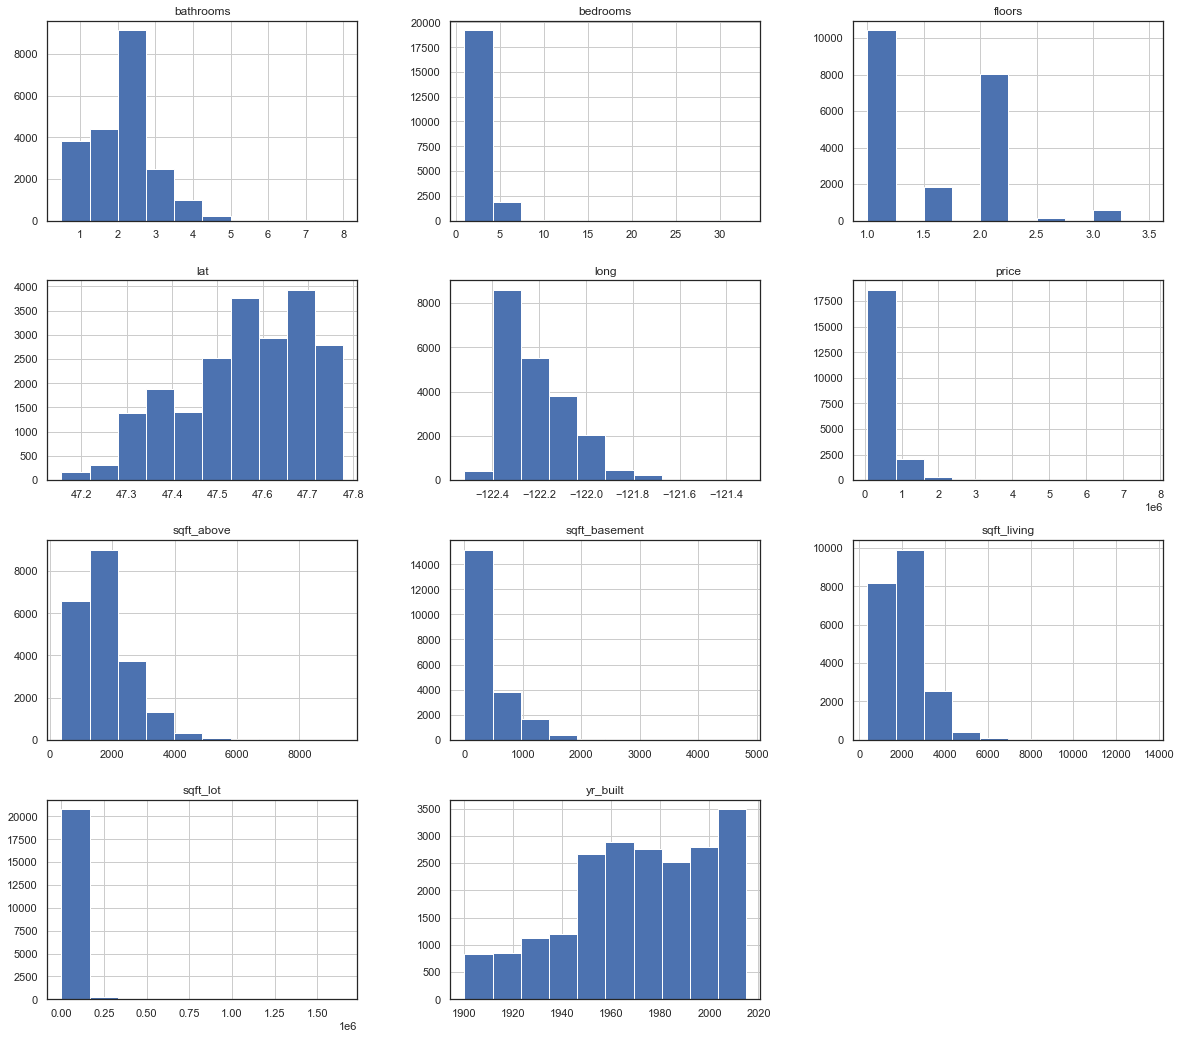

In [1159]:
df.hist(figsize = (20,18));

Note how skewed most of these distributions are. While linear regression does not assume that each of the individual predictors are normally distributed, it does assume a linear relationship between the predictors and the target variable

### Check for Linearity

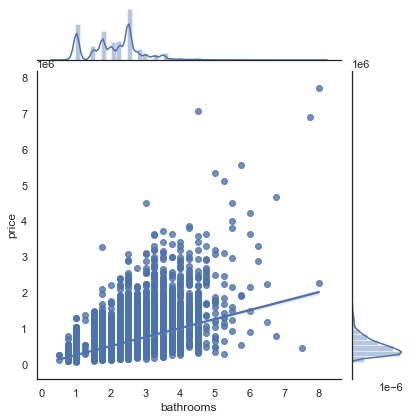

In [1160]:
sns.jointplot('bathrooms','price', data=df, kind='reg');

In [1161]:
# Comment: There seems to be a some-what linear correlation between num_reviews and list_price
# Though the relationship is noisy

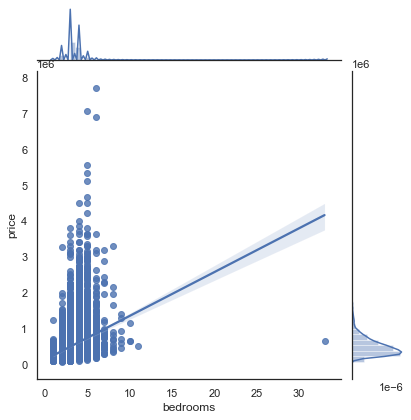

In [1162]:
sns.jointplot('bedrooms','price', data=df, kind='reg');

In [1163]:
# Not much of a linear relationship

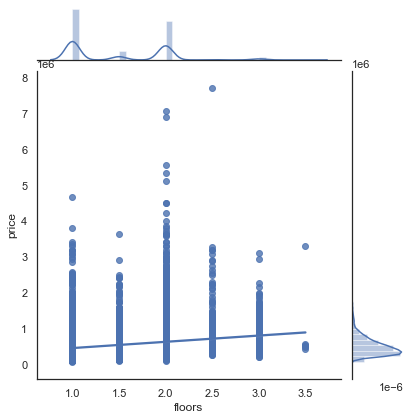

In [1164]:
sns.jointplot('floors','price', data=df, kind='reg');

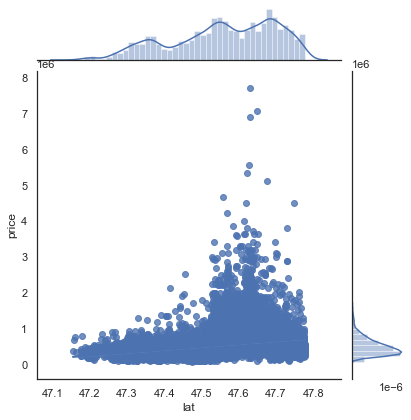

In [1165]:
sns.jointplot('lat','price', data=df, kind='reg');

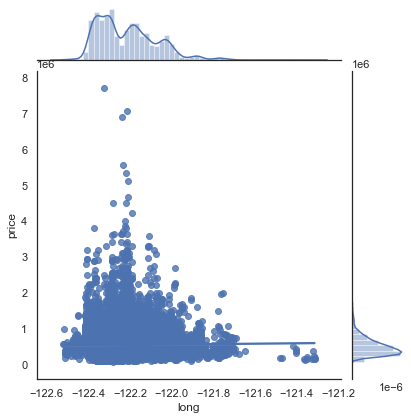

In [1166]:
sns.jointplot('long','price', data=df, kind='reg');

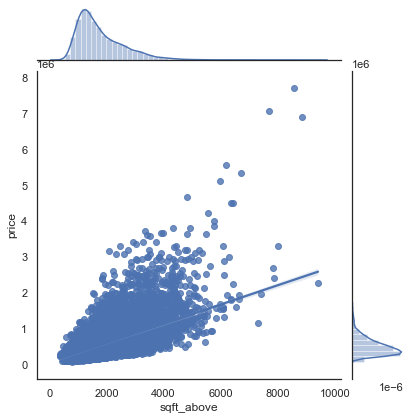

In [1167]:
sns.jointplot('sqft_above','price', data=df, kind='reg');

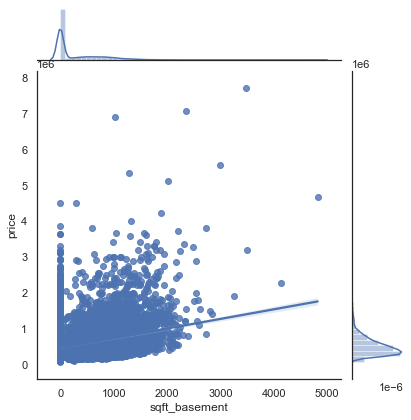

In [1168]:
sns.jointplot('sqft_basement','price', data=df, kind='reg');

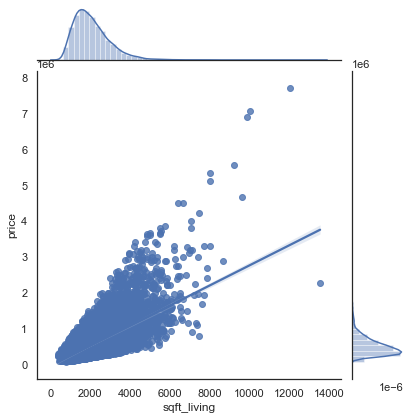

In [1169]:
sns.jointplot('sqft_living','price', data=df, kind='reg');

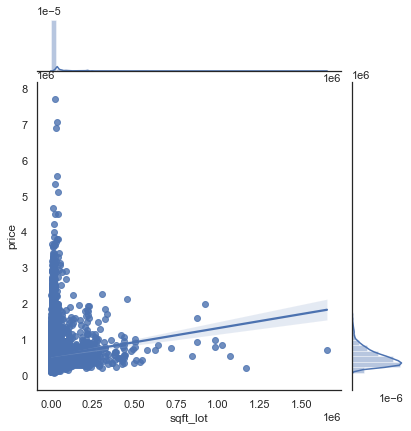

In [1170]:
sns.jointplot('sqft_lot','price', data=df, kind='reg');

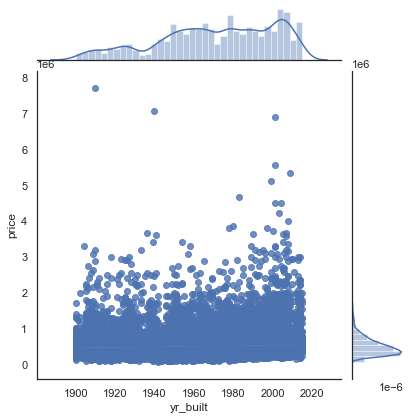

In [1171]:
sns.jointplot('yr_built','price', data=df, kind='reg');

## Check for Multicollinearity

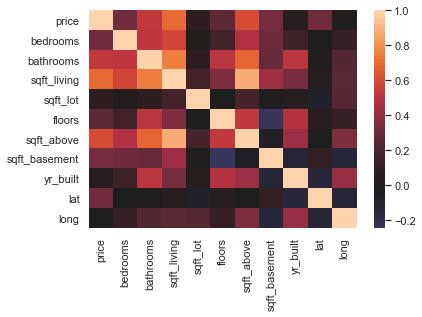

In [1172]:
sns.heatmap(df.corr(), center=0);

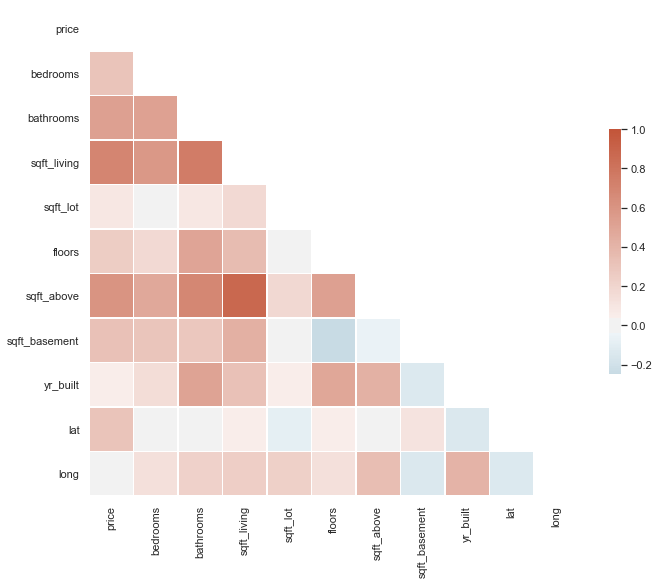

In [1173]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [1174]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
price,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.605481,0.323018,0.054849,0.307667,0.022512
bedrooms,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,0.478967,0.301987,0.156820,-0.009939,0.131398
bathrooms,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.685959,0.281813,0.508866,0.025243,0.224660
sqft_living,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.876787,0.433369,0.319584,0.053213,0.241473
sqft_lot,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.183653,0.015612,0.052469,-0.085076,0.230489
floors,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.523594,-0.245628,0.489898,0.049237,0.125360
sqft_above,0.605481,0.478967,0.685959,0.876787,0.183653,0.523594,1.000000,-0.053403,0.425170,-0.000014,0.344774
sqft_basement,0.323018,0.301987,0.281813,0.433369,0.015612,-0.245628,-0.053403,1.000000,-0.133178,0.110526,-0.144709
yr_built,0.054849,0.156820,0.508866,0.319584,0.052469,0.489898,0.425170,-0.133178,1.000000,-0.148165,0.409009
lat,0.307667,-0.009939,0.025243,0.053213,-0.085076,0.049237,-0.000014,0.110526,-0.148165,1.000000,-0.135173


In [1175]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
price,True,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,False,True,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,True,False,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False
lat,False,False,False,False,False,False,False,False,False,True,False


In [1176]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [1177]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876787
"(sqft_living, bathrooms)",0.754793


In [1178]:
# Drop sqft_living as it is highly correlated to sqft_above and bathrooms
df.drop('sqft_living', axis = 1, inplace = True)

In [1179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  int64  
 2   bathrooms      21082 non-null  float64
 3   sqft_lot       21082 non-null  int64  
 4   floors         21082 non-null  float64
 5   waterfront     21082 non-null  object 
 6   view           21082 non-null  object 
 7   condition      21082 non-null  object 
 8   grade          21082 non-null  object 
 9   sqft_above     21082 non-null  int64  
 10  sqft_basement  21082 non-null  float64
 11  yr_built       21082 non-null  int64  
 12  zipcode        21082 non-null  object 
 13  lat            21082 non-null  float64
 14  long           21082 non-null  float64
dtypes: float64(6), int64(4), object(5)
memory usage: 2.6+ MB


## Normalize Data

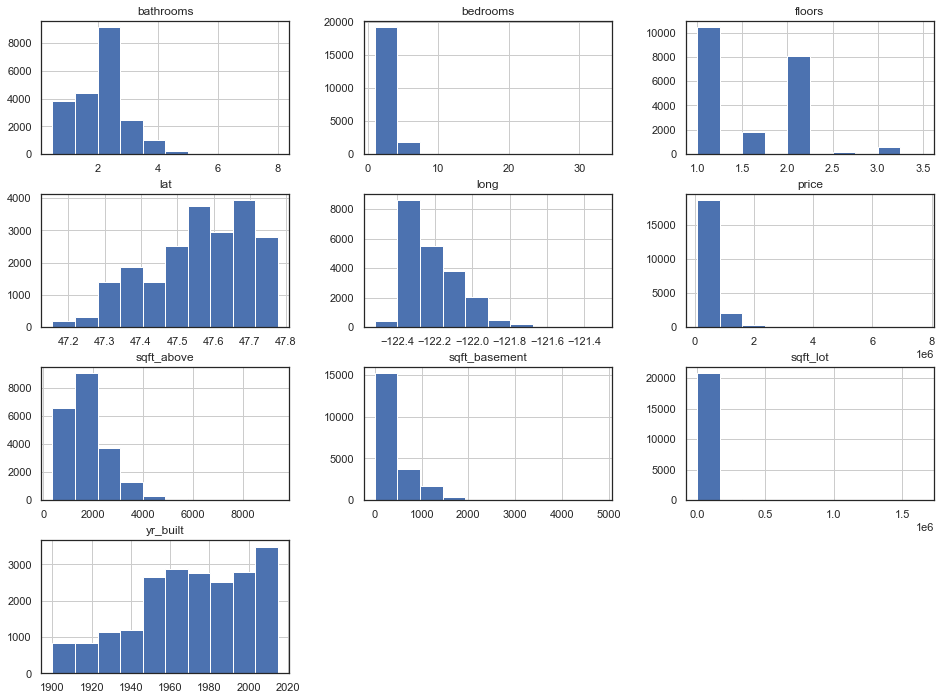

In [1180]:
df.hist(figsize=(16,12));

In [1181]:
# Log transform to reduce skewness
# Don't bother to normalize the price as this is the feature you will be predicting
cont_data = ['bathrooms', 'bedrooms', 'floors', 'lat', 'sqft_above', 'sqft_lot', 'yr_built']
for var in cont_data:
    df[var]= np.log(df[var])
df.describe()

#(Also remember that you can't take the logarithm of zero nor a negative number.)
#will not work on log negatives and sqft_basement due to 0s

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
count,2.108200e+04,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,1.177712,0.677803,8.990663,0.338189,7.395389,291.359975,7.586197,3.861996,-122.213843
std,3.667323e+05,0.282684,0.392118,0.901414,0.352171,0.427009,442.007858,0.014932,0.002916,0.140607
min,7.800000e+04,0.000000,-0.693147,6.253829,0.000000,5.913503,0.000000,7.549609,3.853459,-122.519000
25%,3.220000e+05,1.098612,0.559616,8.525161,0.000000,7.090077,0.000000,7.576610,3.860126,-122.328000
50%,4.500000e+05,1.098612,0.810930,8.938532,0.405465,7.352441,0.000000,7.588324,3.862249,-122.230000
75%,6.450000e+05,1.386294,0.916291,9.277789,0.693147,7.700748,560.000000,7.599401,3.864474,-122.125000
max,7.700000e+06,3.496508,2.079442,14.317109,1.252763,9.149528,4820.000000,7.608374,3.866557,-121.315000


In [1182]:
# Standardization (z-score normalization)
# x' will have mean  𝜇=0  and  𝜎=1 
# Note that standardization does not make data  𝑚𝑜𝑟𝑒  normal, it will just change the mean and the standard error!
for item in cont_data:
    df[item] = (df[item] - df[item].mean()) / df[item].std()

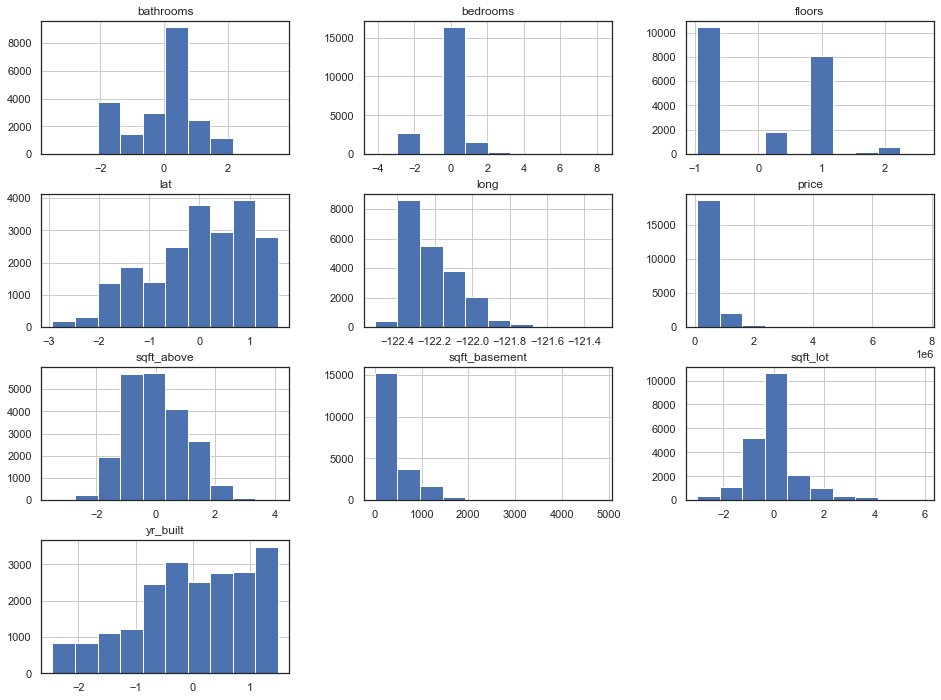

In [1183]:
df.hist(figsize=(16,12));

In [1184]:
# One-hot encode categorical data
df = pd.get_dummies(df, drop_first = True) 
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,-0.279815,-1.728568,-0.389668,-0.960295,-0.754362,0.0,-0.539199,-0.353321,-122.257,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,-0.279815,0.339508,-0.114277,1.007914,0.672337,400.0,-0.676360,1.157882,-122.319,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,-1.714154,-1.728568,0.243703,-0.960295,-1.754058,0.0,-1.297086,1.279324,-122.233,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.737865,1.073170,-0.525253,-0.960295,-1.027715,910.0,-0.197520,-0.284026,-122.393,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,-0.279815,0.039132,0.007193,-0.960295,0.072974,0.0,0.548094,0.408155,-122.045,...,0,0,0,0,0,0,0,0,0,0


In [1185]:
for col in df.columns: 
    print(col) 

price
bedrooms
bathrooms
sqft_lot
floors
sqft_above
sqft_basement
yr_built
lat
long
waterfront_1.0
view_1.0
view_2.0
view_3.0
view_4.0
condition_2
condition_3
condition_4
condition_5
grade_11
grade_12
grade_13
grade_3
grade_4
grade_5
grade_6
grade_7
grade_8
grade_9
zipcode_98002
zipcode_98003
zipcode_98004
zipcode_98005
zipcode_98006
zipcode_98007
zipcode_98008
zipcode_98010
zipcode_98011
zipcode_98014
zipcode_98019
zipcode_98022
zipcode_98023
zipcode_98024
zipcode_98027
zipcode_98028
zipcode_98029
zipcode_98030
zipcode_98031
zipcode_98032
zipcode_98033
zipcode_98034
zipcode_98038
zipcode_98039
zipcode_98040
zipcode_98042
zipcode_98045
zipcode_98052
zipcode_98053
zipcode_98055
zipcode_98056
zipcode_98058
zipcode_98059
zipcode_98065
zipcode_98070
zipcode_98072
zipcode_98074
zipcode_98075
zipcode_98077
zipcode_98092
zipcode_98102
zipcode_98103
zipcode_98105
zipcode_98106
zipcode_98107
zipcode_98108
zipcode_98109
zipcode_98112
zipcode_98115
zipcode_98116
zipcode_98117
zipcode_98118
zipcod

In [1186]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,21082.000000,2.108200e+04,2.108200e+04,21082.000000,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,2.485392e-13,-2.282493e-13,-4.924482e-14,-1.180081e-13,2.384871e-13,291.359975,3.345576e-11,-3.366850e-12,-122.213843,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,3.667323e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,442.007858,1.000000e+00,1.000000e+00,0.140607,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,7.800000e+04,-4.166173e+00,-3.496268e+00,-3.036158e+00,-9.602954e-01,-3.470388e+00,0.000000,-2.450246e+00,-2.927854e+00,-122.519000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,-2.798151e-01,-3.014067e-01,-5.164131e-01,-9.602954e-01,-7.150016e-01,0.000000,-6.420433e-01,-6.412973e-01,-122.328000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,-2.798151e-01,3.395084e-01,-5.783302e-02,1.910334e-01,-1.005779e-01,0.000000,1.424252e-01,8.675308e-02,-122.230000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,7.378647e-01,6.082042e-01,3.185282e-01,1.007914e+00,7.151120e-01,560.000000,8.842844e-01,8.501308e-01,-122.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,8.202777e+00,3.574532e+00,5.908993e+00,2.596958e+00,4.107971e+00,4820.000000,1.485206e+00,1.564437e+00,-121.315000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Explore Data

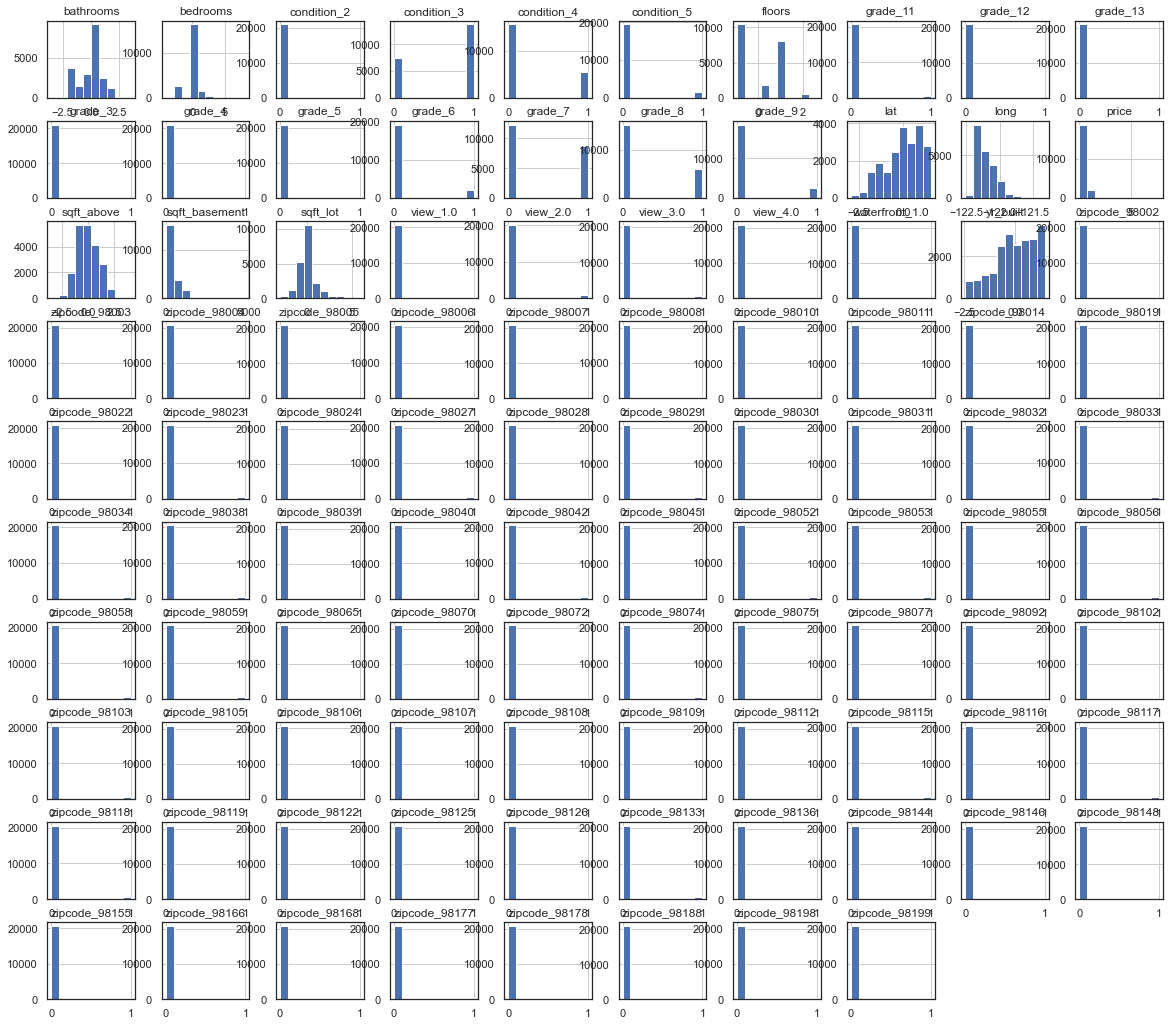

In [1187]:
df.hist(figsize = (20,18));

## Model

In [1188]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [1189]:
df.columns = [col_formatting(col) for col in df.columns]

In [1190]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'waterfront_10',
 'view_10',
 'view_20',
 'view_30',
 'view_40',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_9

In [1191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 98 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21082 non-null  float64
 1   bedrooms       21082 non-null  float64
 2   bathrooms      21082 non-null  float64
 3   sqft_lot       21082 non-null  float64
 4   floors         21082 non-null  float64
 5   sqft_above     21082 non-null  float64
 6   sqft_basement  21082 non-null  float64
 7   yr_built       21082 non-null  float64
 8   lat            21082 non-null  float64
 9   long           21082 non-null  float64
 10  waterfront_10  21082 non-null  uint8  
 11  view_10        21082 non-null  uint8  
 12  view_20        21082 non-null  uint8  
 13  view_30        21082 non-null  uint8  
 14  view_40        21082 non-null  uint8  
 15  condition_2    21082 non-null  uint8  
 16  condition_3    21082 non-null  uint8  
 17  condition_4    21082 non-null  uint8  
 18  condit

## 5. Build an Initial Regression Model

In [1192]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [1193]:
train, test = train_test_split(df)

In [1194]:
print(len(train), len(test))
train.head()

15811 5271


,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4676,1130000.0,0.737865,-0.301407,0.050281,-0.960295,-0.582228,1100.0,-0.745046,0.802649,-122.264,...,0,0,0,0,0,0,0,0,0,0
1327,788500.0,0.737865,0.339508,3.120552,1.007914,1.013210,0.0,0.210208,-0.745534,-122.020,...,0,0,0,0,0,0,0,0,0,0
12729,135000.0,-0.279815,-1.728568,0.056865,-0.960295,-0.876574,400.0,-0.333982,-1.678389,-122.337,...,0,0,0,0,0,0,0,0,0,0
17138,750000.0,-0.279815,0.608204,2.392102,1.007914,1.399400,0.0,0.649129,-1.157009,-122.420,...,0,0,0,0,0,0,0,0,0,0
11141,515000.0,-0.279815,0.039132,-1.193326,1.007914,0.247520,0.0,0.277921,0.367816,-122.115,...,0,0,0,0,0,0,0,0,0,0


In [1195]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4647,125000.0,-4.166173,-1.728568,-0.084353,-0.960295,-2.765238,0.0,-1.470536,-0.252270,-122.362,...,0,0,0,0,0,0,0,0,0,0
18800,567500.0,0.737865,-0.301407,-0.512020,-0.960295,-0.734599,1000.0,-0.710694,0.176142,-122.387,...,0,0,0,0,0,0,0,0,0,0
16032,780000.0,-0.279815,0.039132,-0.322991,-0.960295,-0.509606,1300.0,-1.020497,0.827110,-122.289,...,0,0,0,0,0,0,0,0,0,0
7619,730000.0,1.527239,1.073170,0.425344,-0.960295,-0.115638,950.0,0.006654,0.068007,-122.127,...,0,0,0,0,0,0,0,0,0,0
10851,232000.0,-0.279815,-0.694530,0.383208,-0.960295,-0.370788,0.0,-0.265716,-1.168587,-122.186,...,0,0,0,0,0,0,0,0,0,0


In [1196]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     755.6
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:25   Log-Likelihood:            -2.1159e+05
No. Observations:               15811   AIC:                         4.234e+05
Df Residuals:                   15713   BIC:                         4.241e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.129e+07   6.18e+06     -5.063      0.000   -4.34e+07   -1.92e+07
bedrooms      -1.024e+04   1741.583     -5.880      0.000   -1.37e+04   -6826.898
bathrooms      1.188e+04   2273.974      5.222      0.000    7418.235    1.63e+04
sqft_lot       2.335e+04   1915.189     12.193      0.000    1.96e+04    2.71e+04
floors        -6701.9904   2090.437     -3.206      0.001   -1.08e+04   -2604.494
sqft_above     1.207e+05   2889.766     41.782      0.000    1.15e+05    1.26e+05
sqft_basement   114.4927      3.946     29.013      0.000     106.758     122.228
yr_built      -5651.0451   2152.941     -2.625      0.009   -9871.057   -1431.033
lat            3.564e+04      1e+04      3.549      0.000     1.6e+04    5.53e+04
long          -2.597e+05   5.05e+04     -5.138      0.000   -3.59e+05   -1.61e+05
waterfront_10  6.129e+05   1.89e+04     32.475      0.000    5.76e+05     6.5e+05
view_10        9.978e+04   1.04e+04      9.582      0.000    7.94e+04     1.2e+05
view_20        6.726e+04   6434.499     10.453      0.000    5.46e+04    7.99e+04
view_30        1.695e+05   8719.066     19.442      0.000    1.52e+05    1.87e+05
view_40        2.822e+05   1.34e+04     21.087      0.000    2.56e+05    3.08e+05
condition_2    8.923e+04   3.99e+04      2.238      0.025    1.11e+04    1.67e+05
condition_3    1.139e+05   3.76e+04      3.030      0.002    4.02e+04    1.88e+05
condition_4    1.334e+05   3.76e+04      3.547      0.000    5.97e+04    2.07e+05
condition_5    1.796e+05   3.78e+04      4.750      0.000    1.05e+05    2.54e+05
grade_11       2.606e+05   1.06e+04     24.555      0.000     2.4e+05    2.81e+05
grade_12       7.237e+05   2.01e+04     35.984      0.000    6.84e+05    7.63e+05
grade_13       1.925e+06   4.83e+04     39.845      0.000    1.83e+06    2.02e+06
grade_3       -5561.3211   1.58e+05     -0.035      0.972   -3.16e+05    3.05e+05
grade_4       -1.859e+05   3.79e+04     -4.908      0.000    -2.6e+05   -1.12e+05
grade_5       -2.386e+05   1.53e+04    -15.631      0.000   -2.69e+05   -2.09e+05
grade_6       -2.622e+05   9592.182    -27.331      0.000   -2.81e+05   -2.43e+05
grade_7       -2.794e+05   7621.343    -36.657      0.000   -2.94e+05   -2.64e+05
grade_8       -2.568e+05   6767.639    -37.944      0.000    -2.7e+05   -2.44e+05
grade_9       -1.595e+05   6704.784    -23.796      0.000   -1.73e+05   -1.46e+05
zipcode_98002  2.704e+04   1.64e+04      1.651      0.099   -5063.192    5.92e+04
zipcode_98003 -2.016e+04   1.49e+04     -1.357      0.175   -4.93e+04    8952.218
zipcode_98004  7.373e+05   2.68e+04     27.496      0.000    6.85e+05     7.9e+05
zipcode_98005  2.514e+05   2.87e+04      8.768      0.000    1.95e+05    3.08e+05
zipcode_98006  2.231e+05   2.34e+04      9.536      0.000    1.77e+05    2.69e+05
zipcode_98007  2.104e+05   2.96e+04      7.119   

## Remove the Uninfluential Features

In [1197]:
# Based on the initial model, remove those features which do not appear to be statistically relevant and rerun the model.
# Extract the p-value table from the summary and use it to subset our features (p < 0.05)
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

98 76
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-3.129e+07,6.18e+06,-5.063,0.000,-4.34e+07,-1.92e+07
bedrooms,-1.024e+04,1741.583,-5.880,0.000,-1.37e+04,-6826.898
bathrooms,1.188e+04,2273.974,5.222,0.000,7418.235,1.63e+04
sqft_lot,2.335e+04,1915.189,12.193,0.000,1.96e+04,2.71e+04
floors,-6701.9904,2090.437,-3.206,0.001,-1.08e+04,-2604.494


In [1198]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     963.5
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:25   Log-Likelihood:            -2.1160e+05
No. Observations:               15811   AIC:                         4.234e+05
Df Residuals:                   15734   BIC:                         4.240e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.369e+07   2.97e+06     -7.979      0.000   -2.95e+07   -1.79e+07
bedrooms      -1.035e+04   1739.668     -5.948      0.000   -1.38e+04   -6937.730
bathrooms      1.204e+04   2270.658      5.303      0.000    7591.464    1.65e+04
sqft_lot       2.271e+04   1881.962     12.069      0.000     1.9e+04    2.64e+04
floors        -6513.7542   2080.224     -3.131      0.002   -1.06e+04   -2436.277
sqft_above      1.21e+05   2881.243     41.990      0.000    1.15e+05    1.27e+05
sqft_basement   114.1250      3.940     28.963      0.000     106.401     121.849
yr_built      -5808.5824   2138.896     -2.716      0.007      -1e+04   -1616.101
lat             4.75e+04   1959.171     24.244      0.000    4.37e+04    5.13e+04
long          -1.977e+05   2.43e+04     -8.141      0.000   -2.45e+05    -1.5e+05
waterfront_10  6.126e+05   1.88e+04     32.498      0.000    5.76e+05     6.5e+05
view_10         9.97e+04   1.04e+04      9.583      0.000    7.93e+04     1.2e+05
view_20        6.667e+04   6416.073     10.392      0.000    5.41e+04    7.92e+04
view_30        1.696e+05   8708.533     19.479      0.000    1.53e+05    1.87e+05
view_40        2.837e+05   1.34e+04     21.221      0.000    2.57e+05     3.1e+05
condition_2     8.83e+04   3.98e+04      2.219      0.027    1.03e+04    1.66e+05
condition_3    1.126e+05   3.75e+04      3.002      0.003    3.91e+04    1.86e+05
condition_4    1.328e+05   3.75e+04      3.540      0.000    5.93e+04    2.06e+05
condition_5    1.789e+05   3.77e+04      4.744      0.000    1.05e+05    2.53e+05
grade_11       2.606e+05   1.06e+04     24.564      0.000     2.4e+05    2.81e+05
grade_12       7.237e+05   2.01e+04     35.989      0.000    6.84e+05    7.63e+05
grade_13       1.926e+06   4.83e+04     39.850      0.000    1.83e+06    2.02e+06
grade_4       -1.828e+05   3.78e+04     -4.831      0.000   -2.57e+05   -1.09e+05
grade_5        -2.38e+05   1.52e+04    -15.662      0.000   -2.68e+05   -2.08e+05
grade_6       -2.614e+05   9514.831    -27.477      0.000    -2.8e+05   -2.43e+05
grade_7       -2.789e+05   7575.168    -36.823      0.000   -2.94e+05   -2.64e+05
grade_8       -2.566e+05   6740.019    -38.071      0.000    -2.7e+05   -2.43e+05
grade_9       -1.597e+05   6691.120    -23.860      0.000   -1.73e+05   -1.47e+05
zipcode_98004  7.054e+05   1.06e+04     66.426      0.000    6.85e+05    7.26e+05
zipcode_98005  2.176e+05   1.45e+04     15.002      0.000    1.89e+05    2.46e+05
zipcode_98006  1.926e+05   9054.102     21.274      0.000    1.75e+05     2.1e+05
zipcode_98007  1.748e+05   1.58e+04     11.060      0.000    1.44e+05    2.06e+05
zipcode_98008  1.977e+05   1.17e+04     16.853      0.000    1.75e+05    2.21e+05
zipcode_98010  1.078e+05   1.92e+04      5.628      0.000    7.03e+04    1.45e+05
zipcode_98014  4.707e+04   1.87e+04      2.515   

Comment: You should see that the model performance is identical. Additionally, observe that there are further features which have been identified as unimpactful. Continue to refine the model accordingly.

In [1199]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

77 76
['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-2.369e+07,2.97e+06,-7.979,0.000,-2.95e+07,-1.79e+07
bedrooms,-1.035e+04,1739.668,-5.948,0.000,-1.38e+04,-6937.730
bathrooms,1.204e+04,2270.658,5.303,0.000,7591.464,1.65e+04
sqft_lot,2.271e+04,1881.962,12.069,0.000,1.9e+04,2.64e+04
floors,-6513.7542,2080.224,-3.131,0.002,-1.06e+04,-2436.277


In [1200]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     963.5
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:25   Log-Likelihood:            -2.1160e+05
No. Observations:               15811   AIC:                         4.234e+05
Df Residuals:                   15734   BIC:                         4.240e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.369e+07   2.97e+06     -7.979      0.000   -2.95e+07   -1.79e+07
bedrooms      -1.035e+04   1739.668     -5.948      0.000   -1.38e+04   -6937.730
bathrooms      1.204e+04   2270.658      5.303      0.000    7591.464    1.65e+04
sqft_lot       2.271e+04   1881.962     12.069      0.000     1.9e+04    2.64e+04
floors        -6513.7542   2080.224     -3.131      0.002   -1.06e+04   -2436.277
sqft_above      1.21e+05   2881.243     41.990      0.000    1.15e+05    1.27e+05
sqft_basement   114.1250      3.940     28.963      0.000     106.401     121.849
yr_built      -5808.5824   2138.896     -2.716      0.007      -1e+04   -1616.101
lat             4.75e+04   1959.171     24.244      0.000    4.37e+04    5.13e+04
long          -1.977e+05   2.43e+04     -8.141      0.000   -2.45e+05    -1.5e+05
waterfront_10  6.126e+05   1.88e+04     32.498      0.000    5.76e+05     6.5e+05
view_10         9.97e+04   1.04e+04      9.583      0.000    7.93e+04     1.2e+05
view_20        6.667e+04   6416.073     10.392      0.000    5.41e+04    7.92e+04
view_30        1.696e+05   8708.533     19.479      0.000    1.53e+05    1.87e+05
view_40        2.837e+05   1.34e+04     21.221      0.000    2.57e+05     3.1e+05
condition_2     8.83e+04   3.98e+04      2.219      0.027    1.03e+04    1.66e+05
condition_3    1.126e+05   3.75e+04      3.002      0.003    3.91e+04    1.86e+05
condition_4    1.328e+05   3.75e+04      3.540      0.000    5.93e+04    2.06e+05
condition_5    1.789e+05   3.77e+04      4.744      0.000    1.05e+05    2.53e+05
grade_11       2.606e+05   1.06e+04     24.564      0.000     2.4e+05    2.81e+05
grade_12       7.237e+05   2.01e+04     35.989      0.000    6.84e+05    7.63e+05
grade_13       1.926e+06   4.83e+04     39.850      0.000    1.83e+06    2.02e+06
grade_4       -1.828e+05   3.78e+04     -4.831      0.000   -2.57e+05   -1.09e+05
grade_5        -2.38e+05   1.52e+04    -15.662      0.000   -2.68e+05   -2.08e+05
grade_6       -2.614e+05   9514.831    -27.477      0.000    -2.8e+05   -2.43e+05
grade_7       -2.789e+05   7575.168    -36.823      0.000   -2.94e+05   -2.64e+05
grade_8       -2.566e+05   6740.019    -38.071      0.000    -2.7e+05   -2.43e+05
grade_9       -1.597e+05   6691.120    -23.860      0.000   -1.73e+05   -1.47e+05
zipcode_98004  7.054e+05   1.06e+04     66.426      0.000    6.85e+05    7.26e+05
zipcode_98005  2.176e+05   1.45e+04     15.002      0.000    1.89e+05    2.46e+05
zipcode_98006  1.926e+05   9054.102     21.274      0.000    1.75e+05     2.1e+05
zipcode_98007  1.748e+05   1.58e+04     11.060      0.000    1.44e+05    2.06e+05
zipcode_98008  1.977e+05   1.17e+04     16.853      0.000    1.75e+05    2.21e+05
zipcode_98010  1.078e+05   1.92e+04      5.628      0.000    7.03e+04    1.45e+05
zipcode_98014  4.707e+04   1.87e+04      2.515   

## 6. Investigate Multicollinearity

There are still a lot of features in the current model! Chances are there are some strong multicollinearity issues. Begin to investigate the extent of this problem.

In [1201]:
# A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.
# Inf = This shows a perfect correlation between two independent variables. In the case of perfect correlation, we get R2 =1, which lead to 1/(1-R2) infinity. To solve this problem we need to drop one of the variables from the dataset which is causing this perfect multicollinearity.
# need to drop one column for each categorical data is dropped to avoid a singularity occurring (action completed above)
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.9175514334630974),
 ('bathrooms', 3.3197658227064917),
 ('sqft_lot', 2.1838083072657235),
 ('floors', 2.757838429806841),
 ('sqft_above', 5.321607617008851),
 ('sqft_basement', 2.798561143448544),
 ('yr_built', 2.833909331339266),
 ('lat', 2.464383793032544),
 ('long', 808.0877679471552),
 ('waterfront_10', 1.5406100730387697),
 ('view_10', 1.0624324335669635),
 ('view_20', 1.1362238972321181),
 ('view_30', 1.1296016970412395),
 ('view_40', 1.6125424132271868),
 ('condition_2', 6.995178933908655),
 ('condition_3', 500.3120795847225),
 ('condition_4', 202.49971979489843),
 ('condition_5', 61.510225824642426),
 ('grade_11', 1.3876274141666858),
 ('grade_12', 1.1231453869792387),
 ('grade_13', 1.0380406165270468),
 ('grade_4', 1.104368462584849),
 ('grade_5', 1.6678321773869107),
 ('grade_6', 5.515507681457198),
 ('grade_7', 15.424848651602035),
 ('grade_8', 8.266961178735523),
 ('grade_9', 3.5089354839523534),
 ('zipcode_98004', 1.1196841370742523),
 ('zipcode_98005', 1.0

## Perform Another Round of Feature Selection

In [1202]:
# Once again, subset your features based on your findings above. Then rerun the model once again.
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

76 67


In [1203]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     757.6
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:30   Log-Likelihood:            -2.1391e+05
No. Observations:               15811   AIC:                         4.280e+05
Df Residuals:                   15743   BIC:                         4.285e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.386e+05   3194.301    105.994      0.000    3.32e+05    3.45e+05
bedrooms       1.755e+04   1845.658      9.507      0.000    1.39e+04    2.12e+04
bathrooms      6.138e+04   2399.931     25.577      0.000    5.67e+04    6.61e+04
sqft_lot       6.755e+04   1947.020     34.692      0.000    6.37e+04    7.14e+04
floors         4.325e+04   2191.008     19.740      0.000     3.9e+04    4.75e+04
sqft_basement    69.6521      4.281     16.271      0.000      61.262      78.043
yr_built      -8995.6348   2221.323     -4.050      0.000   -1.33e+04   -4641.588
lat            4.825e+04   2257.130     21.376      0.000    4.38e+04    5.27e+04
waterfront_10  6.156e+05   2.18e+04     28.245      0.000    5.73e+05    6.58e+05
view_10        1.341e+05    1.2e+04     11.176      0.000    1.11e+05    1.58e+05
view_20        1.037e+05   7377.676     14.053      0.000    8.92e+04    1.18e+05
view_30        2.306e+05      1e+04     23.033      0.000    2.11e+05     2.5e+05
view_40        3.705e+05   1.54e+04     24.084      0.000     3.4e+05    4.01e+05
grade_11       5.238e+05   1.12e+04     46.874      0.000    5.02e+05    5.46e+05
grade_12       1.004e+06   2.27e+04     44.263      0.000    9.59e+05    1.05e+06
grade_13       2.281e+06   5.55e+04     41.106      0.000    2.17e+06    2.39e+06
grade_4        2.524e+04   4.22e+04      0.598      0.550   -5.75e+04    1.08e+05
grade_5       -1.245e+04    1.4e+04     -0.886      0.376      -4e+04    1.51e+04
grade_9        9.587e+04   4855.956     19.742      0.000    8.63e+04    1.05e+05
zipcode_98004  7.933e+05   1.21e+04     65.491      0.000     7.7e+05    8.17e+05
zipcode_98005  2.694e+05   1.66e+04     16.244      0.000    2.37e+05    3.02e+05
zipcode_98006   2.45e+05      1e+04     24.447      0.000    2.25e+05    2.65e+05
zipcode_98007  1.987e+05    1.8e+04     11.040      0.000    1.63e+05    2.34e+05
zipcode_98008   1.99e+05    1.3e+04     15.271      0.000    1.73e+05    2.25e+05
zipcode_98010  6.032e+04   2.13e+04      2.837      0.005    1.86e+04    1.02e+05
zipcode_98014 -7.467e+04   1.91e+04     -3.908      0.000   -1.12e+05   -3.72e+04
zipcode_98022 -7575.7025    1.5e+04     -0.505      0.614    -3.7e+04    2.19e+04
zipcode_98023 -7203.9549   1.06e+04     -0.679      0.497    -2.8e+04    1.36e+04
zipcode_98024  5.091e+04   2.34e+04      2.177      0.029    5075.678    9.67e+04
zipcode_98027  1.251e+05    1.1e+04     11.337      0.000    1.03e+05    1.47e+05
zipcode_98029  1.826e+05   1.28e+04     14.248      0.000    1.57e+05    2.08e+05
zipcode_98033  2.936e+05   1.11e+04     26.351      0.000    2.72e+05    3.15e+05
zipcode_98034   7.52e+04      1e+04      7.490      0.000    5.55e+04    9.49e+04
zipcode_98038    2.3e+04   9630.304      2.389      0.017    4127.533    4.19e+04
zipcode_98039  1.201e+06   3.12e+04     38.485   

## Check the Normality Assumption

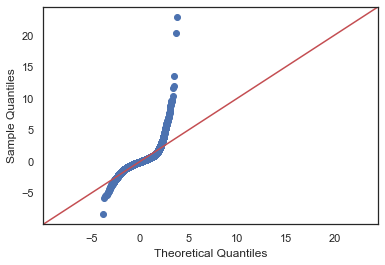

In [1204]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

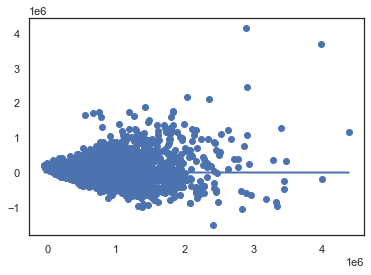

In [1205]:
# Check whether the model's errors are indeed homoscedastic or if they violate this principle and display heteroscedasticity.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Comment: This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Make Additional Refinements

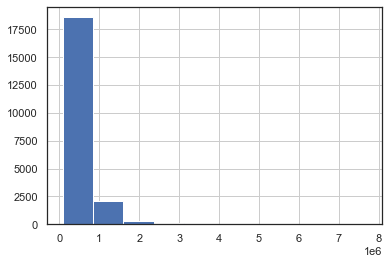

In [1206]:
# From here, make additional refinements to your model based on the above analysis. As you progress, continue to go back and check the assumptions for the updated model. Be sure to attempt at least two additional model refinements.
#Comment: Based on the above plots, it seems as though outliers are having a substantial impact on the model. As such, removing outliers may be appropriate. Investigating the impact of a log transformation is also worthwhile.
df.price.hist();

In [1207]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.8 percentile: 702000.0
0.81 percentile: 719000.0
0.82 percentile: 732000.0
0.83 percentile: 750000.0
0.84 percentile: 762000.0
0.85 percentile: 780000.0
0.86 percentile: 799000.0
0.87 percentile: 815000.0
0.88 percentile: 838327.9999999999
0.89 percentile: 860000.0
0.9 percentile: 888999.0
0.91 percentile: 920000.0
0.92 percentile: 950000.0
0.93 percentile: 997966.5000000001
0.94 percentile: 1070000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [1208]:
orig_tot = len(df)
df = df[df.price < 1300000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.list_price = df.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

Percent removed: 0.037377857888245894


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     685.8
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:31   Log-Likelihood:            -1.9874e+05
No. Observations:               15220   AIC:                         3.976e+05
Df Residuals:                   15153   BIC:                         3.981e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.492e+05   2026.329    172.310      0.000    3.45e+05    3.53e+05
bedrooms        1.66e+04   1172.560     14.160      0.000    1.43e+04    1.89e+04
bathrooms      5.059e+04   1547.865     32.682      0.000    4.76e+04    5.36e+04
sqft_lot       5.518e+04   1258.227     43.857      0.000    5.27e+04    5.76e+04
floors         3.217e+04   1408.785     22.833      0.000    2.94e+04    3.49e+04
sqft_basement    38.6670      2.889     13.382      0.000      33.003      44.331
yr_built      -8331.6758   1432.943     -5.814      0.000   -1.11e+04   -5522.936
lat            4.929e+04   1413.446     34.869      0.000    4.65e+04    5.21e+04
waterfront_10  1.509e+05   2.03e+04      7.448      0.000    1.11e+05    1.91e+05
view_10         9.97e+04   7954.684     12.533      0.000    8.41e+04    1.15e+05
view_20        9.569e+04   4810.545     19.893      0.000    8.63e+04    1.05e+05
view_30        1.455e+05   6974.655     20.865      0.000    1.32e+05    1.59e+05
view_40        2.366e+05   1.15e+04     20.580      0.000    2.14e+05    2.59e+05
grade_11        3.26e+05   9440.757     34.533      0.000    3.08e+05    3.45e+05
grade_12       2.957e+05   4.04e+04      7.312      0.000    2.16e+05    3.75e+05
grade_13       1.842e-08   4.15e-09      4.439      0.000    1.03e-08    2.66e-08
grade_4       -1.484e+04   2.51e+04     -0.591      0.554    -6.4e+04    3.43e+04
grade_5       -4.026e+04   8964.773     -4.491      0.000   -5.78e+04   -2.27e+04
grade_9        1.103e+05   3156.964     34.952      0.000    1.04e+05    1.17e+05
zipcode_98004   4.79e+05      1e+04     47.677      0.000    4.59e+05    4.99e+05
zipcode_98005  2.808e+05   1.09e+04     25.674      0.000    2.59e+05    3.02e+05
zipcode_98006  2.477e+05   6592.244     37.577      0.000    2.35e+05    2.61e+05
zipcode_98007  2.024e+05   1.13e+04     17.845      0.000     1.8e+05    2.25e+05
zipcode_98008  1.653e+05   8013.566     20.629      0.000     1.5e+05    1.81e+05
zipcode_98010  6.474e+04    1.3e+04      4.987      0.000    3.93e+04    9.02e+04
zipcode_98014 -7.001e+04   1.24e+04     -5.645      0.000   -9.43e+04   -4.57e+04
zipcode_98022  1.023e+04   9654.264      1.060      0.289   -8691.018    2.92e+04
zipcode_98023 -1721.4624   6495.592     -0.265      0.791   -1.45e+04     1.1e+04
zipcode_98024  3.264e+04   1.53e+04      2.132      0.033    2637.987    6.26e+04
zipcode_98027  1.484e+05   7038.691     21.079      0.000    1.35e+05    1.62e+05
zipcode_98029  1.746e+05   7947.337     21.973      0.000    1.59e+05     1.9e+05
zipcode_98033  2.282e+05   7318.791     31.184      0.000    2.14e+05    2.43e+05
zipcode_98034  5.043e+04   6406.353      7.871      0.000    3.79e+04     6.3e+04
zipcode_98038  2.064e+04   6049.045      3.412      0.001    8784.779    3.25e+04
zipcode_98039  5.822e+05   4.02e+04     14.465   

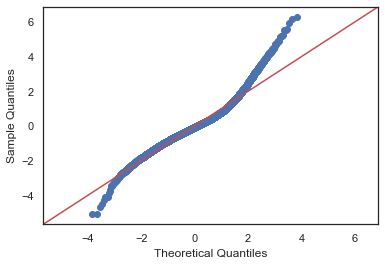

In [1209]:
# Comment: This is much, much better!
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

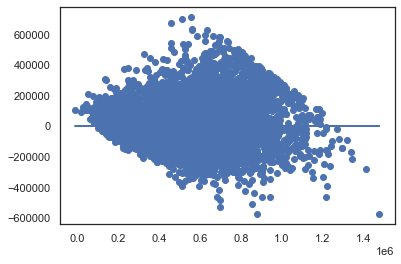

In [1210]:
# Comment: There is still a clear underestimate now by the model as the log transformed 
# list price increases, but the model is much improved. Further subsetting is potentially warranted.
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

0.8 percentile: 665000.0
0.81 percentile: 677000.0
0.82 percentile: 690000.0
0.83 percentile: 700000.0
0.84 percentile: 716000.0
0.85 percentile: 730000.0
0.86 percentile: 745992.8199999998
0.87 percentile: 760000.0
0.88 percentile: 775000.0
0.89 percentile: 790000.0
0.9 percentile: 809665.0000000007
0.91 percentile: 829000.0
0.92 percentile: 850000.0
0.93 percentile: 875000.0
0.94 percentile: 900000.0
0.95 percentile: 932802.8
0.96 percentile: 970000.0
0.97 percentile: 1020000.0
0.98 percentile: 1100000.0
0.99 percentile: 1200000.0


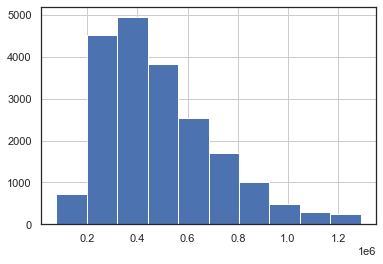

In [1211]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

df.price.hist()

In [1212]:
df = df[df.price <= 1000000]
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     638.3
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:52:33   Log-Likelihood:            -1.9068e+05
No. Observations:               14745   AIC:                         3.815e+05
Df Residuals:                   14678   BIC:                         3.820e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.515e+05   1810.708    194.126      0.000    3.48e+05    3.55e+05
bedrooms        1.77e+04   1045.569     16.926      0.000    1.56e+04    1.97e+04
bathrooms      4.513e+04   1382.239     32.649      0.000    4.24e+04    4.78e+04
sqft_lot        4.95e+04   1118.946     44.239      0.000    4.73e+04    5.17e+04
floors         2.857e+04   1259.797     22.674      0.000    2.61e+04     3.1e+04
sqft_basement    29.9491      2.640     11.343      0.000      24.774      35.125
yr_built      -9909.1400   1291.602     -7.672      0.000   -1.24e+04   -7377.438
lat            4.948e+04   1256.960     39.361      0.000     4.7e+04    5.19e+04
waterfront_10  1.119e+05   1.88e+04      5.959      0.000    7.51e+04    1.49e+05
view_10        8.425e+04   7500.129     11.234      0.000    6.96e+04     9.9e+04
view_20        7.594e+04   4490.469     16.910      0.000    6.71e+04    8.47e+04
view_30        1.016e+05   6739.157     15.080      0.000    8.84e+04    1.15e+05
view_40        1.958e+05   1.23e+04     15.968      0.000    1.72e+05     2.2e+05
grade_11        2.57e+05   1.22e+04     21.088      0.000    2.33e+05    2.81e+05
grade_12      -1.874e+05   1.01e+05     -1.851      0.064   -3.86e+05    1.11e+04
grade_13      -6.144e-10   1.33e-10     -4.617      0.000   -8.75e-10   -3.54e-10
grade_4       -1.532e+04   2.39e+04     -0.642      0.521   -6.21e+04    3.14e+04
grade_5       -4.185e+04   7877.360     -5.313      0.000   -5.73e+04   -2.64e+04
grade_9        1.076e+05   2862.734     37.580      0.000    1.02e+05    1.13e+05
zipcode_98004  4.258e+05   1.06e+04     40.300      0.000    4.05e+05    4.46e+05
zipcode_98005  2.795e+05   9817.370     28.466      0.000     2.6e+05    2.99e+05
zipcode_98006  2.351e+05   6284.235     37.406      0.000    2.23e+05    2.47e+05
zipcode_98007  1.744e+05   1.01e+04     17.259      0.000    1.55e+05    1.94e+05
zipcode_98008  1.599e+05   7397.004     21.613      0.000    1.45e+05    1.74e+05
zipcode_98010  7.577e+04   1.17e+04      6.457      0.000    5.28e+04    9.88e+04
zipcode_98014 -5.409e+04   1.07e+04     -5.040      0.000   -7.51e+04   -3.31e+04
zipcode_98022  3.005e+04   8367.571      3.592      0.000    1.37e+04    4.65e+04
zipcode_98023 -2234.8774   5835.767     -0.383      0.702   -1.37e+04    9203.959
zipcode_98024   3.49e+04   1.33e+04      2.626      0.009    8849.454     6.1e+04
zipcode_98027  1.434e+05   6171.024     23.238      0.000    1.31e+05    1.55e+05
zipcode_98029  1.766e+05   7052.382     25.047      0.000    1.63e+05     1.9e+05
zipcode_98033   2.01e+05   6839.683     29.387      0.000    1.88e+05    2.14e+05
zipcode_98034  5.058e+04   5728.380      8.829      0.000    3.93e+04    6.18e+04
zipcode_98038   2.66e+04   5266.725      5.050      0.000    1.63e+04    3.69e+04
zipcode_98039  6.059e+05   4.49e+04     13.499   

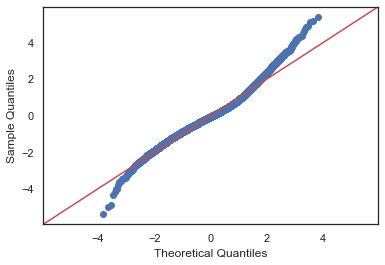

In [1213]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

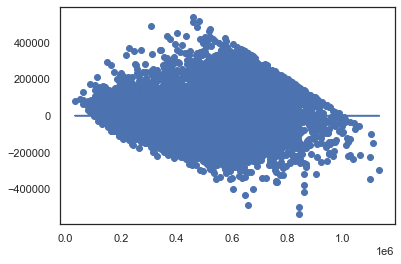

In [1214]:
# Check the Homoscedasticity Assumption
# Comment: No improvement observed
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

In [1215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19660 entries, 0 to 21596
Data columns (total 98 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19660 non-null  float64
 1   bedrooms       19660 non-null  float64
 2   bathrooms      19660 non-null  float64
 3   sqft_lot       19660 non-null  float64
 4   floors         19660 non-null  float64
 5   sqft_above     19660 non-null  float64
 6   sqft_basement  19660 non-null  float64
 7   yr_built       19660 non-null  float64
 8   lat            19660 non-null  float64
 9   long           19660 non-null  float64
 10  waterfront_10  19660 non-null  uint8  
 11  view_10        19660 non-null  uint8  
 12  view_20        19660 non-null  uint8  
 13  view_30        19660 non-null  uint8  
 14  view_40        19660 non-null  uint8  
 15  condition_2    19660 non-null  uint8  
 16  condition_3    19660 non-null  uint8  
 17  condition_4    19660 non-null  uint8  
 18  condit

In [1225]:
for col in df[x_cols].columns: 
    print(col) 

bedrooms
bathrooms
sqft_lot
floors
sqft_basement
yr_built
lat
waterfront_10
view_10
view_20
view_30
view_40
grade_11
grade_12
grade_13
grade_4
grade_5
grade_9
zipcode_98004
zipcode_98005
zipcode_98006
zipcode_98007
zipcode_98008
zipcode_98010
zipcode_98014
zipcode_98022
zipcode_98023
zipcode_98024
zipcode_98027
zipcode_98029
zipcode_98033
zipcode_98034
zipcode_98038
zipcode_98039
zipcode_98040
zipcode_98042
zipcode_98045
zipcode_98052
zipcode_98053
zipcode_98056
zipcode_98059
zipcode_98065
zipcode_98070
zipcode_98072
zipcode_98074
zipcode_98075
zipcode_98102
zipcode_98103
zipcode_98105
zipcode_98106
zipcode_98107
zipcode_98108
zipcode_98109
zipcode_98112
zipcode_98115
zipcode_98116
zipcode_98117
zipcode_98118
zipcode_98119
zipcode_98122
zipcode_98125
zipcode_98126
zipcode_98136
zipcode_98144
zipcode_98177
zipcode_98198
zipcode_98199


## Cross validation

In [1217]:
X = df[x_cols]
y = df['price']

### Train-test split

Perform a train-test split with a test set of 20%.

In [1218]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [1219]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

15728 3932 15728 3932


#### Fit the model

In [1220]:
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

#### Residuals and MSE

In [1221]:
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

9886777857.386112

## Cross-Validation using Scikit-Learn

In [1222]:
#Now, let's perform 5-fold cross-validation to get the mean squared error through scikit-learn. Let's have a look at the five individual MSEs and explain what's going on.
mse = make_scorer(mean_squared_error)

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [1223]:
#Next, calculate the mean of the MSE over the 5 cross-validation and compare and contrast with the result from the train-test split case.
cv_5_results.mean()

10246890522.367208

# LET'S TRY WITHOUT ZIP CODES